In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

df = pd.read_csv('oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
df.shape

(373, 15)

In [3]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [4]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

(15.3, 30.0)

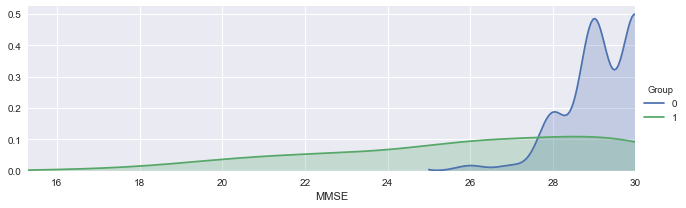

In [6]:

facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)


(0.6, 0.9)

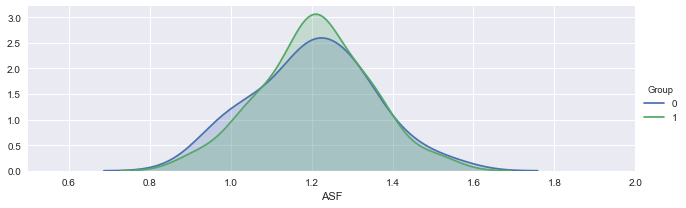

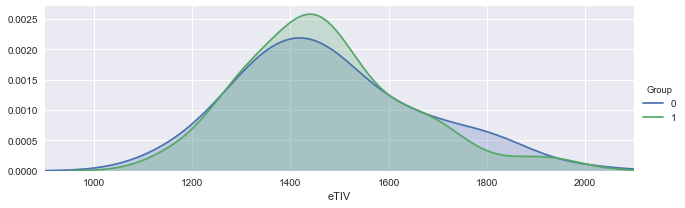

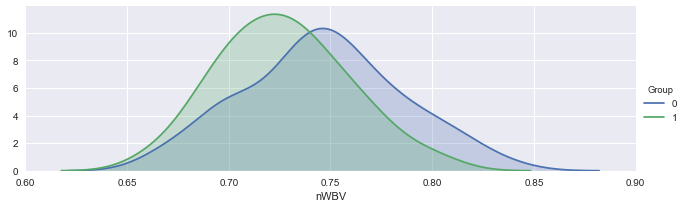

In [7]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

#The chart indicates that Nondemented group has higher brain volume ratio than Demented group. This is assumed to be because the diseases affect the brain to be shrinking its tissue. 

(50, 100)

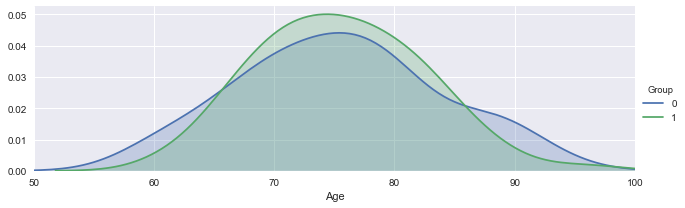

In [8]:
#AGE. Nondemented =0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

#There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients.
#We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.

(0, 0.16)

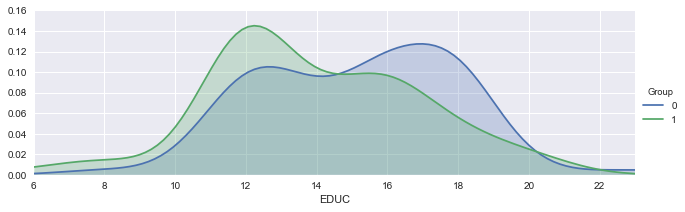

In [9]:
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

In [11]:
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [12]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [13]:
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()

False    150
Name: SES, dtype: int64

In [14]:
df.head()

,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,1,0,1,75,12,3.0,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,0,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,0,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,1,0,1,71,16,2.0,28.0,0.5,1357,0.748,1.293


In [15]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

In [16]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

# # Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense 


model= Sequential()

model.add(Dense(activation = 'relu',  input_dim = 8, units = 12, kernel_initializer = 'uniform'))
model.add(Dense( activation = 'relu', units = 12, kernel_initializer = 'uniform'))
model.add(Dense( activation = 'relu', units = 12, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'sigmoid', units = 1, kernel_initializer = 'uniform' ))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(X_trainval_scaled, Y_trainval, batch_size = 10, epochs = 100)

y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)   
print(cm)


Epoch 1/100
112/112 [==============================] - 0s 4ms/step - loss: 0.6932 - acc: 0.5089
Epoch 2/100
112/112 [==============================] - 0s 230us/step - loss: 0.6931 - acc: 0.5179
Epoch 3/100
112/112 [==============================] - 0s 266us/step - loss: 0.6931 - acc: 0.5179
Epoch 4/100
112/112 [==============================] - 0s 249us/step - loss: 0.6931 - acc: 0.5179
Epoch 5/100
112/112 [==============================] - 0s 323us/step - loss: 0.6931 - acc: 0.5179
Epoch 6/100
112/112 [==============================] - 0s 339us/step - loss: 0.6930 - acc: 0.5179
Epoch 7/100
112/112 [==============================] - 0s 301us/step - loss: 0.6932 - acc: 0.5179
Epoch 8/100
112/112 [==============================] - 0s 359us/step - loss: 0.6929 - acc: 0.5179
Epoch 9/100
112/112 [==============================] - 0s 277us/step - loss: 0.6929 - acc: 0.5179
Epoch 10/100
112/112 [==============================] - 0s 242us/step - loss: 0.6926 - acc: 0.5179
Epoch 11/100
112/112 

In [18]:
# splitting into three sets
# X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(X, Y, random_state=0)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

In [20]:
acc = [] # list to store all performance metric

In [21]:
# Dataset with imputation
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7541125541125542
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.7894736842105263
Test recall with the best C parameter is 0.75
Test AUC with the best C parameter is 0.7916666666666667


In [22]:


for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
            

# rebuild a model with best parameters to get score 
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on cross validation set is: 0.7715038584603802
Best parameter for c is:  100
Best parameter for gamma is:  0.1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is 0.7
Test recall with the best parameter is 0.8222222222222222


In [23]:
best_score = 0

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set        
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval )

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7785431959345004
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825


In [24]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedDTModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U4')

In [25]:
# from sklearn.tree import export_graphviz

In [26]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set        
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7963297571993225
Best parameters of M, d, m are:  14 5 7
Test accuracy with the best parameters is 0.8421052631578947
Test recall with the best parameters is: 0.8
Test AUC with the best parameters is: 0.8444444444444443


In [29]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.03503132427481025'],
       ['Age', '0.09551237125526228'],
       ['EDUC', '0.06261556797214127'],
       ['SES', '0.060620327518549066'],
       ['MMSE', '0.4006565962793097'],
       ['eTIV', '0.07005497528287095'],
       ['nWBV', '0.1460571117936201'],
       ['ASF', '0.1294517256234364']], dtype='<U20')

In [28]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr

# Rebuild a model on the combined training and validation set        
SelectedBoostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7785431959345004
Best parameter of M is:  2
best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.8421052631578947
Test recall with the best parameters is: 0.65
Test AUC with the best parameters is: 0.825


In [32]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedBoostModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.07142857142857142'],
       ['Age', '0.14285714285714285'],
       ['EDUC', '0.21428571428571427'],
       ['SES', '0.07142857142857142'],
       ['MMSE', '0.14285714285714285'],
       ['eTIV', '0.21428571428571427'],
       ['nWBV', '0.14285714285714285'],
       ['ASF', '0.0']], dtype='<U19')

In [29]:
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Logistic Regression (w/ imputation),0.789474,0.75,0.791667
1,SVM,0.815789,0.70,0.822222
2,Decision Tree,0.815789,0.65,0.825000
3,Random Forest,0.842105,0.80,0.844444
4,AdaBoost,0.842105,0.65,0.825000
